# Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from mltools import plot_data, plot_frontiere, make_grid, gen_arti

# Loss and gradient functions

In [2]:
def mse(w,x,y):
    if len(x) > 2:
        return np.mean((x@w - y)**2)
    else:
        return np.mean((x*w-y)**2)

def mse_grad(w,x,y):
    if len(x) > 2:
        return np.mean(1/x.shape[0] * 2 * (x.T @ x @ w - x.T @ y))
    else:
        return np.mean(2 * (w*x**2 - x*y))

def reglog(w,x,y):
    return np.mean(np.log(1 + np.exp(-y * (x @ w))))

def reglog_grad(w,x,y):
    return np.mean(1 / (1+np.exp(-y*(x@w))) * (-y*x) * np.exp(-y * (x@w)), axis=0).reshape(-1,1)

In [3]:
np.random.seed(0)
datax, datay = gen_arti(epsilon=0.1)
wrandom = np.random.randn(datax.shape[1],1)
assert(np.isclose(mse(wrandom,datax,datay).mean(),0.54731,rtol=1e-4))
assert(np.isclose(reglog(wrandom,datax,datay).mean(), 0.57053,rtol=1e-4))
assert(np.isclose(mse_grad(wrandom,datax,datay).mean(),-1.43120,rtol=1e-4))
assert(np.isclose(reglog_grad(wrandom,datax,datay).mean(),-0.42714,rtol=1e-4))
np.random.seed()

# Testing data generation and plots

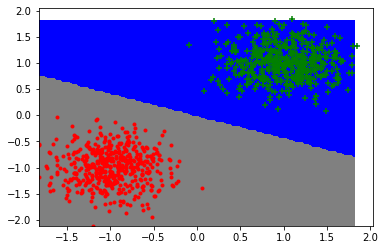

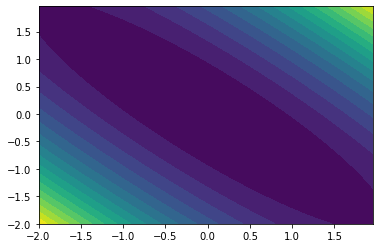

In [4]:
## Tirage d'un jeu de données aléatoire avec un bruit de 0.1
datax, datay = gen_arti(epsilon=0.1)
## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)
plt.figure()
## Visualisation des données et de la frontière de décision pour un vecteur de poids w
w  = np.random.randn(datax.shape[1],1)
plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
plot_data(datax,datay)
## Visualisation de la fonction de coût en 2D
plt.figure()
plt.contourf(x_grid,y_grid,np.array([mse(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)

# Gradient descent

In [5]:
def descente_gradient(x, y, f_loss, f_grad, eps, n_iter):
    list_w = []
    list_l = []
    w = np.random.randn(datax.shape[1], 1)
    for _ in tqdm(range(n_iter)):
        w = w - eps * f_grad(w, x, y)
        list_w.append(w)
        list_l.append(f_loss(w, x, y))
    return list_w, list_l, w

def descente_gradient_stoch(x, y, f_loss, f_grad, eps, n_iter):
    list_w = []
    list_l = []
    w = np.random.randn(datax.shape[1], 1)
    for _ in tqdm(range(n_iter)):
        for _ in range(x.shape[0]):
            rand_idx = np.random.randint(x.shape[0])
            w = w - eps * f_grad(w, x[rand_idx], y[rand_idx])
        list_w.append(w)
        list_l.append(f_loss(w, x, y))
    return list_w, list_l, w

def descente_gradient_minibatch(x, y, f_loss, f_grad, eps, n_iter):
    list_w = []
    list_l = []
    n = x.shape[0]
    w = np.random.randn(x.shape[1], 1)
    n_batch = 20
    batch_size = n//n_batch
    for _ in tqdm(range(n_iter)):
        for _ in range(n_batch):
            rand_idx = np.random.randint(1, n_batch-1)
            w = w - eps * f_grad(w, x[rand_idx*batch_size:rand_idx*(batch_size+1)], y[rand_idx*batch_size:rand_idx*(batch_size+1)])
        list_w.append(w)
        list_l.append(f_loss(w, x, y))
    return list_w, list_l, w

# Several test of different loss functions and gradient descent algorithms

In [6]:
def analysis(lw,ll,w):
    plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
    plot_data(datax,datay)
    plt.title("Classification")
    plt.show()
    
    plt.plot(ll)
    plt.title("Loss/epochs")
    plt.show()
    
    lw = np.array(lw)
    lw = np.array(lw)
    lw_w1, lw_w2 = lw[:,0], lw[:,1]
    plt.plot(lw_w1)
    plt.plot(lw_w2)
    plt.title("w1 and w2/epochs")
    plt.show()

In [7]:
n_epochs = 500
learning_rate = 1e-2

## --> Reglog + batch gradient descent

In [8]:
lw, ll, w = descente_gradient(datax, datay, reglog, reglog_grad, learning_rate, n_epochs)

100%|██████████| 500/500 [00:00<00:00, 7061.24it/s]


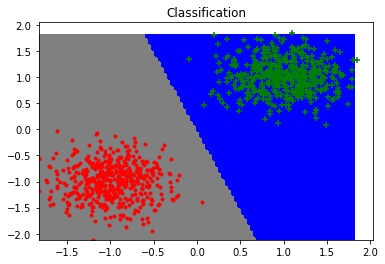

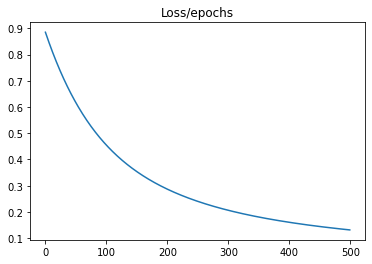

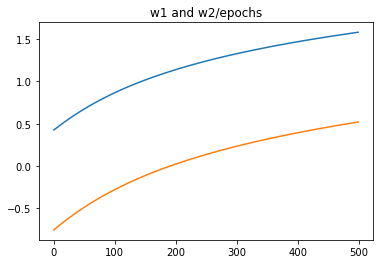

In [9]:
analysis(lw,ll,w)

## --> MSE + batch gradient descent

In [10]:
lw, ll, w = descente_gradient(datax, datay, mse, mse_grad, learning_rate, n_epochs)

100%|██████████| 500/500 [00:00<00:00, 8355.59it/s]


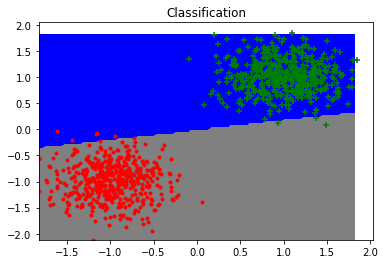

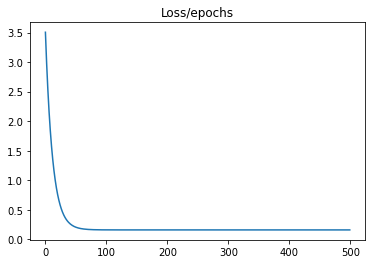

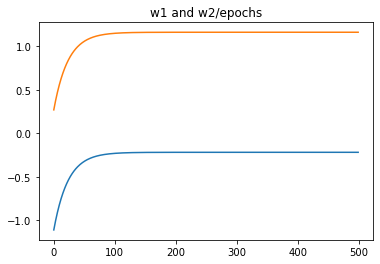

In [11]:
analysis(lw,ll,w)

## --> MSE + stochastic gradient descent

In [12]:
lw, ll, w = descente_gradient_stoch(datax, datay, mse, mse_grad, learning_rate, n_epochs)

100%|██████████| 500/500 [00:11<00:00, 42.44it/s]


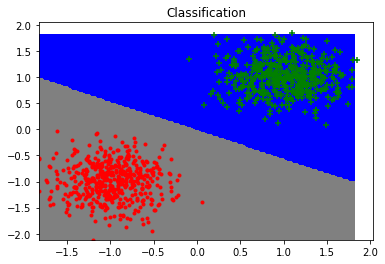

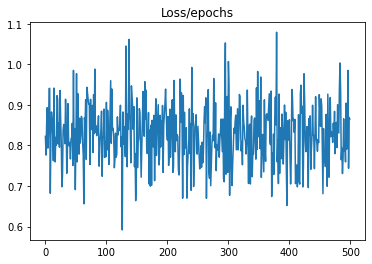

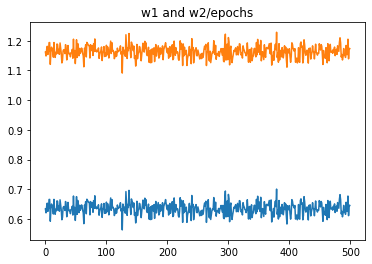

In [13]:
analysis(lw,ll,w)

## --> MSE + minibatch gradient descent

In [14]:
lw, ll, w = descente_gradient_minibatch(datax, datay, mse, mse_grad, learning_rate, n_epochs)

100%|██████████| 500/500 [00:00<00:00, 1836.20it/s]


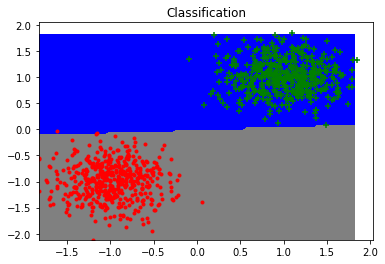

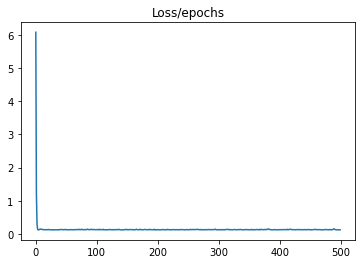

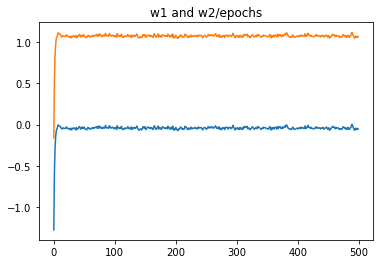

In [15]:
analysis(lw,ll,w)

# Testing learning rate

## --> Linearly separable case

In [16]:
def lr_analysis(lw_tab, ll_tab, w_tab, lrs):
    lw_tab = np.array(lw_tab)
    ll_tab = np.array(ll_tab)
    w_tab = np.array(w_tab)
    lw_tab = lw_tab.reshape(lw_tab.shape[0], lw_tab.shape[1], lw_tab.shape[2])
    w_tab = w_tab.reshape(w_tab.shape[0], w_tab.shape[1])
    
    for i in range(w_tab.shape[0]):
        plot_frontiere(datax,lambda x : np.sign(x.dot(w_tab[i])),step=100)
        plot_data(datax,datay)
        plt.title("Classification with lr ="+str(lrs[i]))
        plt.show()
    
    lw_w1, lw_w2 = lw_tab[:,:,0], lw_tab[:,:,1]
    plt.figure(figsize=(8, 8))
    plt.plot(lw_w1.T)
    plt.legend(lrs)
    plt.title("w1/epochs")
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.plot(lw_w2.T)
    plt.legend(lrs)
    plt.title("w2/epochs")
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.plot(ll_tab.T)
    plt.legend(lrs)
    plt.title("loss/epochs")
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.plot(w_tab.T)
    plt.legend(lrs)
    plt.title("w/epochs")
    plt.show()

In [17]:
n_epochs=1000

In [18]:
lw_tab = []
ll_tab = []
w_tab = []

lrs = np.logspace(-5,-1,5)
for learning_rate in lrs:
    lw, ll, w = descente_gradient_minibatch(datax, datay, mse, mse_grad, learning_rate, n_epochs)
    lw_tab.append(lw)
    ll_tab.append(ll)
    w_tab.append(w)

100%|██████████| 1000/1000 [00:00<00:00, 1809.88it/s]


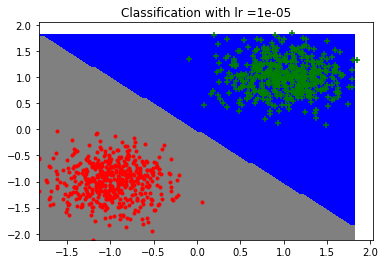

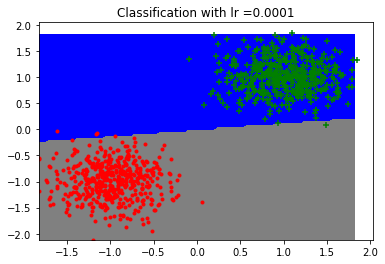

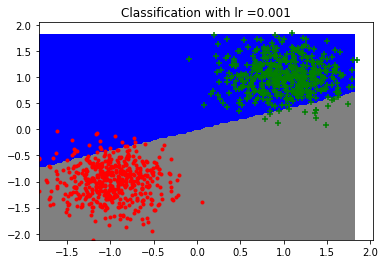

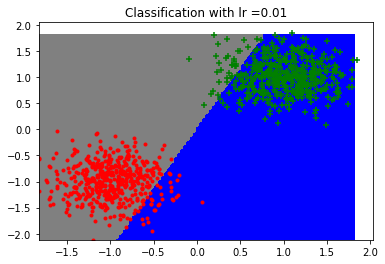

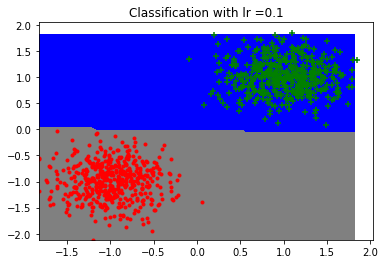

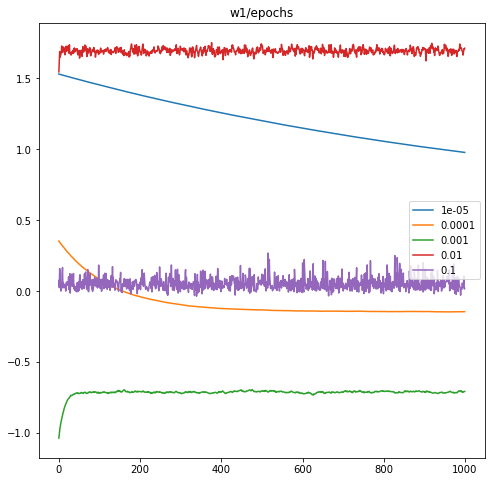

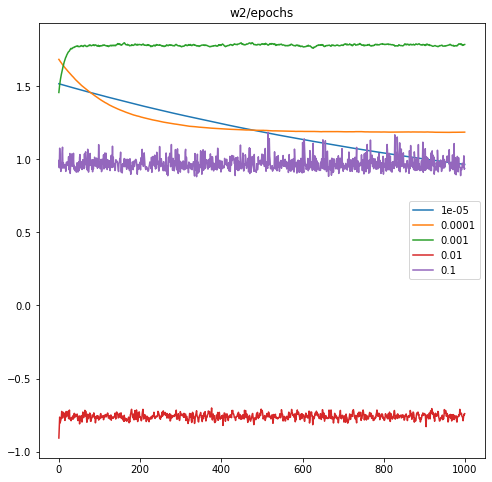

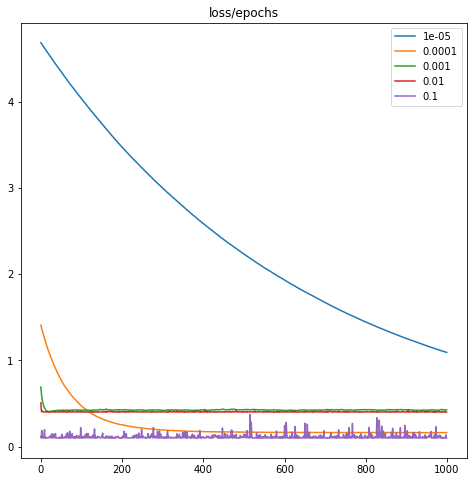

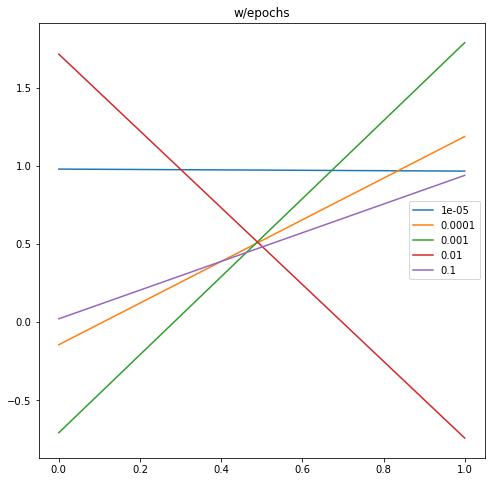

In [19]:
lr_analysis(lw_tab, ll_tab, w_tab, lrs)

## --> Non linearly separable case

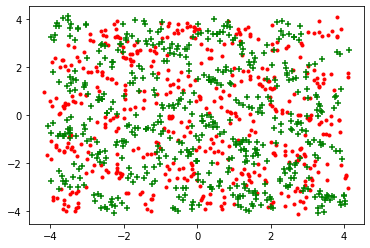

In [28]:
## Tirage d'un jeu de données aléatoire avec un bruit de 0.1
datax, datay = gen_arti(epsilon=0.1, data_type=2)
## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)
plt.figure()
## Visualisation des données et de la frontière de décision pour un vecteur de poids w
w  = np.random.randn(datax.shape[1],1)
plot_data(datax,datay)

In [29]:
lw_tab = []
ll_tab = []
w_tab = []

lrs = np.logspace(-5,-1,5)
for learning_rate in lrs:
    lw, ll, w = descente_gradient_minibatch(datax, datay, mse, mse_grad, learning_rate, n_epochs)
    lw_tab.append(lw)
    ll_tab.append(ll)
    w_tab.append(w)

100%|██████████| 1000/1000 [00:00<00:00, 1874.15it/s]


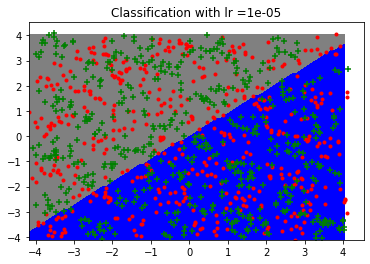

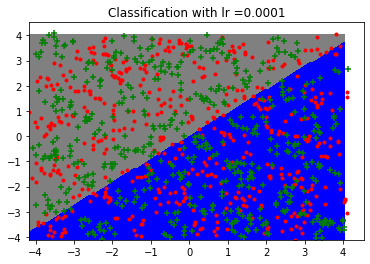

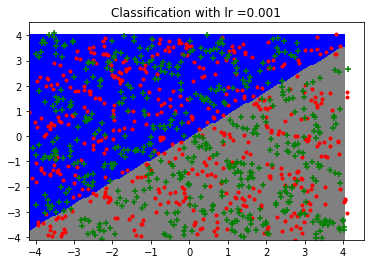

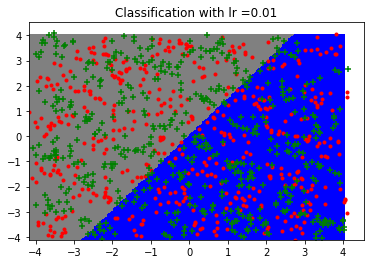

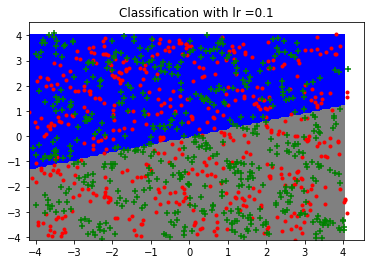

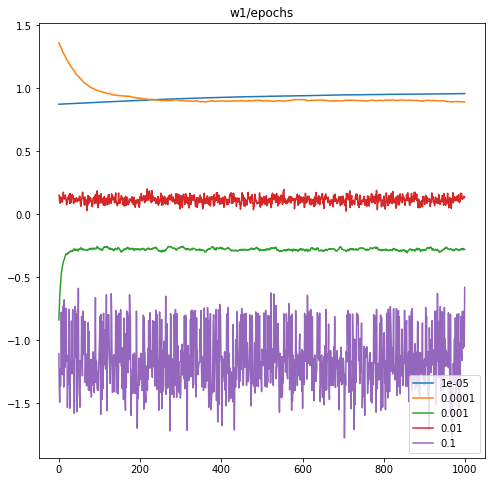

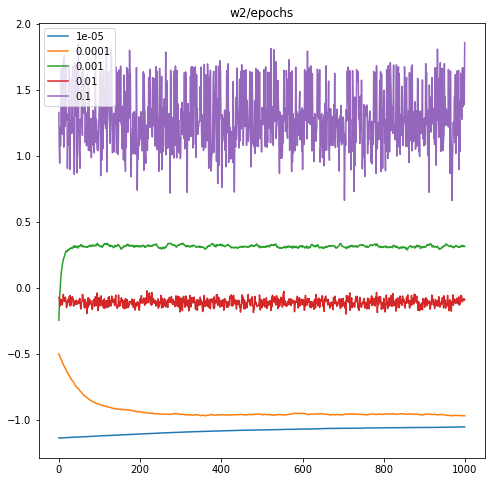

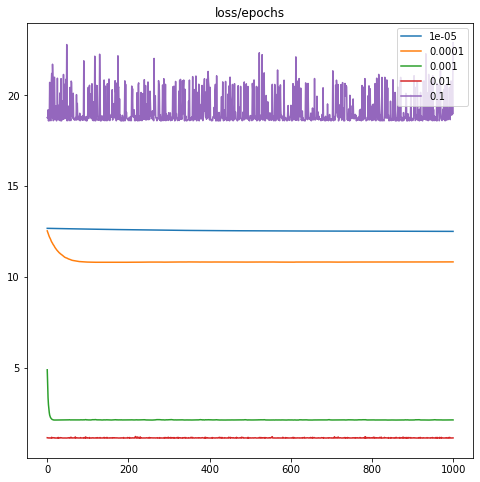

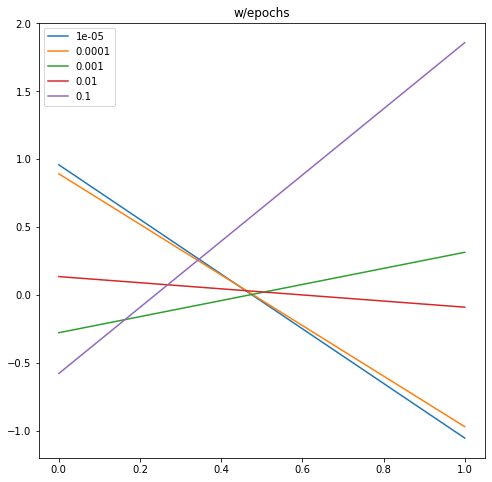

In [30]:
lr_analysis(lw_tab, ll_tab, w_tab, lrs)